### Samantha Beard
#### Term Project Milestone 5

### Set Up

In [72]:
# import libraries
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import sqlite3
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import files
grammy_edition_df = pd.read_csv('grammy_edition.csv')
grammy_awards_df = pd.read_csv('grammy_awards.csv')
top_tracks_df = pd.read_csv('top_tracks.csv')

In [3]:
list(grammy_edition_df.columns)

['Edition',
 'Year',
 'Venue',
 'Venue City',
 'Host',
 'Network',
 'Viewers (in millions)']

In [4]:
list(grammy_awards_df.columns)

['year',
 'title',
 'published_at',
 'category',
 'nominee',
 'artist',
 'workers',
 'img',
 'winner']

In [5]:
list(top_tracks_df.columns)

['name',
 'artist',
 'album',
 'album_type',
 'release_year',
 'track_number',
 'artist_type',
 'explicit',
 'popularity',
 'duration_ms',
 'id',
 'duration_s',
 'duration_m']

In [6]:
top_tracks_df = top_tracks_df.applymap(str)

In [7]:
top_tracks_df['artist'] = top_tracks_df['artist'].str.title()
top_tracks_df['name'] = top_tracks_df['name'].str.title()

### Create Database and Tables

In [8]:
# Connecting to the database
connection = sqlite3.connect('grammySpotify.db')

In [9]:
# Creating a cursor object to execute
# SQL queries on a database table
cursor = connection.cursor()

In [10]:
cursor.execute('''DROP TABLE IF EXISTS grammy_edition''')
cursor.execute('''DROP TABLE IF EXISTS grammy_awards''')
cursor.execute('''DROP TABLE IF EXISTS top_tracks''')
cursor.execute('''DROP TABLE IF EXISTS grammy_spotify_tracks''')

In [11]:
# create tables
cursor.execute('''CREATE TABLE IF NOT EXISTS grammy_edition('Edition','Year','Venue','Venue City','Host','Network',
                'Viewers (in millions)')''')
cursor.execute('''CREATE TABLE IF NOT EXISTS grammy_awards('year', 'title', 'published_at', 'category', 'nominee', 
                'artist', 'workers', 'img', 'winner')''')
cursor.execute('''CREATE TABLE IF NOT EXISTS top_tracks('name', 'artist', 'album', 'album_type', 'release_year', 'track_number',
                'artist_type', 'explicit', 'popularity', 'duration_ms', 'id', 'duration_s', 'duration_m')''')

In [12]:
# add df to db
grammy_edition_df.to_sql('grammy_edition', connection, if_exists='append', index = False)
grammy_awards_df.to_sql('grammy_awards', connection, if_exists='append', index = False)
top_tracks_df.to_sql('top_tracks', connection, if_exists='append', index = False)

5470

In [13]:
# cursor.execute('''DROP TABLE IF EXISTS grammy_spotify_tracks''')

In [1]:
# Query to JOIN all tables based on top tracks and grammy winning songs
sql = '''
    CREATE TABLE IF NOT EXISTS grammy_spotify_tracks
    AS
    SELECT *  
    FROM grammy_awards 
    JOIN grammy_edition
    ON grammy_awards.['Player Name']=grammy_edition.['Player Name']
    ;'''
  
# Executing the query 
cursor.execute(sql) 
  


NameError: name 'cursor' is not defined

In [15]:
# Query to JOIN all tables based on artist's top tracks where the album the song is on won a grammy
sql = '''
    CREATE TABLE IF NOT EXISTS grammy_spotify_albums
    AS
    SELECT *  
    FROM grammy_awards 
    JOIN grammy_edition
    ON grammy_awards.year=grammy_edition.year
    JOIN top_tracks
    ON grammy_awards.nominee=top_tracks.album
    AND grammy_awards.artist=top_tracks.artist
    ;'''
  
# Executing the query 
cursor.execute(sql) 

### Visualization 1

In [16]:
# Retrieve data from tables
cursor.execute('''
    SELECT COUNT(name)
    FROM grammy_spotify_albums''')
count_albums = cursor.fetchall()

In [17]:
count_albums = count_albums[0][0]

In [18]:
cursor.execute('''
    SELECT COUNT(name)
    FROM grammy_spotify_tracks''')
count_tracks = cursor.fetchall()

In [19]:
count_tracks=count_tracks[0][0]

In [20]:
cursor.execute('''
    SELECT COUNT(name)
    FROM top_tracks''')
count_top_tracks = cursor.fetchall()

In [21]:
count_top_tracks=count_top_tracks[0][0]

In [22]:
count_tracks_no_grammy = count_top_tracks - count_tracks - count_albums

In [23]:
count_data = [count_albums, count_tracks, count_tracks_no_grammy]
count_label_list = ['Tracks on Grammy Winning Albums', 'Grammy Winning Tracks', 'Tracks With No Grammys']

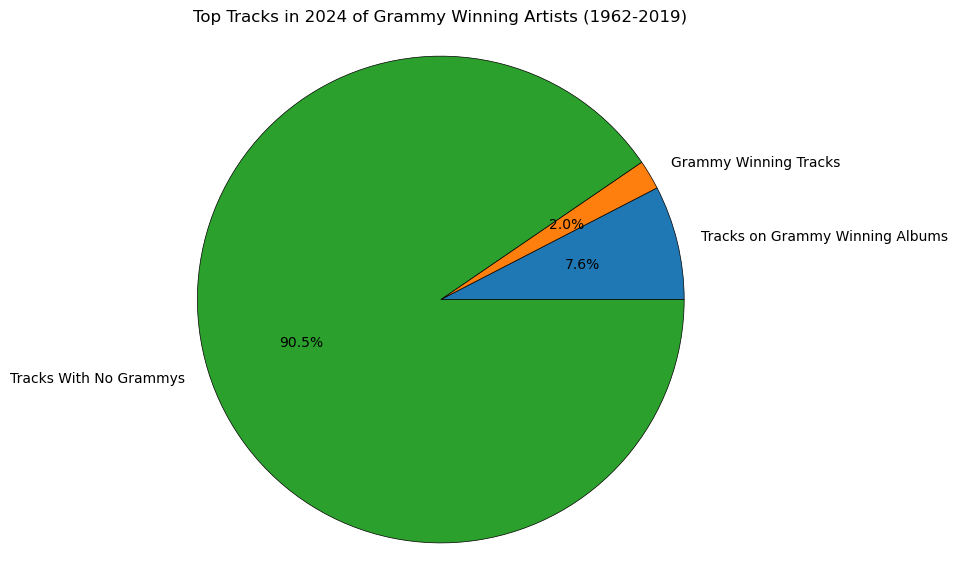

In [24]:
fig= plt.figure(figsize=(10, 7))
plt.pie(count_data, labels=count_label_list, autopct='%1.1f%%',
       wedgeprops = {"edgecolor" : "black", 
                      'linewidth': .5, 
                      'antialiased': True})
plt.title("Top Tracks in 2024 of Grammy Winning Artists (1962-2019)")
plt.axis('equal') 
plt.show()

### Visualization 2

In [30]:
top_tracks_with_grammy = pd.read_sql_query("SELECT * FROM grammy_spotify_tracks",connection)

In [31]:
top_track_albums_with_grammy = pd.read_sql_query("SELECT * FROM grammy_spotify_albums",connection)

In [36]:
all_tracks_with_grammy_df = pd.concat([top_tracks_with_grammy, top_track_albums_with_grammy], axis=0)

In [46]:
# list(all_tracks_with_grammy_df.columns)

In [48]:
# df not to include years without viewer numbers
all_tracks_with_grammy_df = all_tracks_with_grammy_df[all_tracks_with_grammy_df['Viewers (in millions)'] != '—']

In [65]:
# convert from string to float and int
all_tracks_with_grammy_df = all_tracks_with_grammy_df.astype({'duration_m':'float', 'popularity':'int'})
# remove outliers by limiting duration to 10 minutes
all_tracks_with_grammy_df_subset = all_tracks_with_grammy_df[all_tracks_with_grammy_df['duration_m'] <= 10]

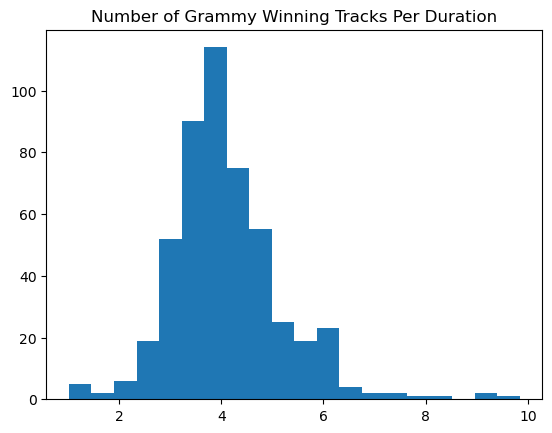

In [69]:
plt.hist(all_tracks_with_grammy_df_subset['duration_m'], bins=20) 
plt.title("Number of Grammy Winning Tracks Per Duration")
plt.show() 

### Visualization 3

AttributeError: 'Text' object has no attribute 'set_xticks'

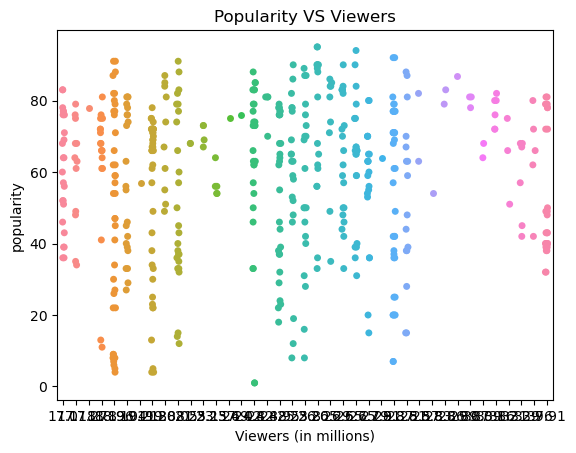

In [102]:
ax = sns.stripplot(x='Viewers (in millions)', y='popularity', data= all_tracks_with_grammy_df, 
              jitter=True).set_title('Popularity VS Viewers')

ax.set_xticks(range(6))
ax.set_xticklabels(['15','20','25','30','35','40'])
ax.show()

### Visualization 4

In [112]:
all_tracks_with_grammy_df_subset2 = all_tracks_with_grammy_df_subset[all_tracks_with_grammy_df_subset['popularity'] > 80]
all_tracks_with_grammy_df_subset2 = all_tracks_with_grammy_df_subset2[all_tracks_with_grammy_df_subset2['duration_m'] < 6]

Text(0.5, 1.0, 'Mean Duration of Most Popular Grammy Tracks')

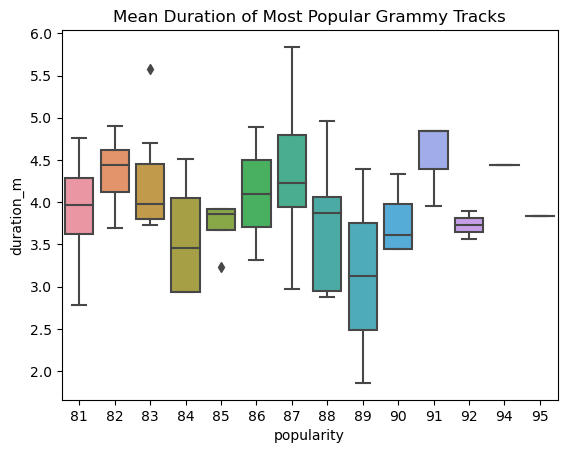

In [113]:
sns.boxplot(x='popularity', y='duration_m', data=all_tracks_with_grammy_df_subset2).set_title('Mean Duration of Most Popular Grammy Tracks')

### Visualization 5

Text(0.5, 1.0, 'Do Explicit Songs Win Grammys')

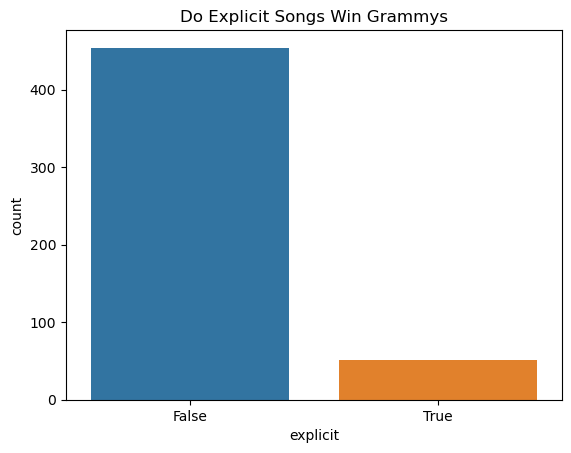

In [115]:
sns.countplot(x ='explicit', data = all_tracks_with_grammy_df).set_title('Do Explicit Songs Win Grammys')

In [116]:
# connection.close()

### Summary

I learned an ton about indexing and getting different types of coding to work together, i.e. python, JSON, and SQL.  I've used these individually before, as well as simple coding projects where JSON and python overlapped.  My biggest struggle was with the API.  The one I originally sourced ended up having very limited data so I swapped subject matter of my API and my flat file.  Because I was using the actual Spotify API, it had nested JSON data that took a long time to figure out how to call and save the data that I wanted.  I also had to scope down my API search because I was trying to pull hundreds of thousands of songs. To call a manageable amount, I imported a list of the grammy winning artists and pulled their top songs to see if they equated to the award winning songs/albums.  Unfortunately, the flat file with grammy award information did not have data for the last 5 years, so this may have skewed the data. I also had difficulties getting the track features that I wanted to analyze due to API limitations in the number of calls and due to some of the calls having null values. Once I was able to get past calling the API and get that information into a dataframe, I was able to easily manipulate the data from all three sources to clean it up and make it useable.  I did find myself making additional changes when working on the last Milestone in order to make the joins easier.  Overall, I enjoyed this project as much as it frustrated me.  I hope to continue to add onto this project to show more complex skills in my portfolio.